In [26]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import inv, hankel
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

sys.path.append('./../../tensor-dynamic-univariate-ts-pytorch/')
from tensordynamicmodel.visuals import plot_phase_trajectory, delay_embedding_matrix
from tensordynamicmodel.utils import delay_embedding_matrix, diag_mean, prepare_time_series, lorenz

In [27]:
# plt.rcParams['font.family'] = 'DejaVu Serif'
# plt.rcParams.update({"text.usetex": False})

In [65]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def hausdorff_distance(A, B):
    """
    Вычисляет расстояние Хаусдорфа между двумя наборами точек
    
    Args:
        A, B: numpy arrays формы (n_points, n_dimensions)
    
    Returns:
        hausdorff_dist: расстояние Хаусдорфа
    """
    # Вычисляем матрицу попарных расстояний
    dist_matrix = cdist(A, B, metric='euclidean')
    
    # max(min(dist(a,B))) для всех a в A
    dist_A_to_B = np.max(np.min(dist_matrix, axis=1))
    
    # max(min(dist(b,A))) для всех b в B  
    dist_B_to_A = np.max(np.min(dist_matrix, axis=0))
    
    return max(dist_A_to_B, dist_B_to_A)

def wasserstein_distance(A, B):
    """
    Вычисляет расстояние Васерштейна (Earth Mover's Distance) между двумя наборами точек
    
    Args:
        A, B: numpy arrays одинаковой формы (n_points, n_dimensions)
    
    Returns:
        wasserstein_dist: расстояние Васерштейна
    """
    # Матрица попарных расстояний
    dist_matrix = cdist(A, B, metric='euclidean')
    
    # Решаем задачу назначения (assignment problem)
    row_ind, col_ind = linear_sum_assignment(dist_matrix)
    
    # Сумма расстояний оптимального назначения
    wasserstein_dist = dist_matrix[row_ind, col_ind].sum() / len(row_ind)
    
    return wasserstein_dist

In [28]:
class LorenzSystem:
    def __init__(self, sigma=10.0, beta=8/3, rho=28.0):
        self.sigma = sigma
        self.beta = beta
        self.rho = rho
    
    def equation(self, t, state):
        x, y, z = state
        dx_dt = self.sigma * (y - x)
        dy_dt = x * (self.rho - z) - y
        dz_dt = x * y - self.beta * z
        return [dx_dt, dy_dt, dz_dt]
    
    def generate_data(self, initial_state, t_span, n_points=10000):
        t_eval = np.linspace(t_span[0], t_span[1], n_points)
        solution = solve_ivp(self.equation, t_span, initial_state, 
                           t_eval=t_eval, method='RK45')
        return solution.t, solution.y

In [29]:
def moving_average_simple(data, window_size):
    """
    Простая реализация скользящего среднего
    """
    moving_avg = []
    for i in range(len(data)):
        if i < window_size - 1:
            # Для первых элементов недостаточно данных
            moving_avg.append(np.nan)
        else:
            # Вычисляем среднее для окна
            window = data[i - window_size + 1:i + 1]
            moving_avg.append(np.mean(window))
    return np.array(moving_avg)
    
def make_ts(person, activity):
    pdf_data_all = pd.read_csv(f'./../data/A_DeviceMotion_data/{activity}/sub_{person}.csv').reset_index(drop=True)
    data_list = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
    data_list_short = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
    pdf_data_all = pdf_data_all[data_list_short]
    xyz = pdf_data_all[data_list_short].to_numpy()
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    return (x**2 + y**2 + z**2)**0.5

def acc_ts_alignment(x, trashhold = 2):
    x = (x - x.mean())/(x.var()**.5)
    i_peak, _ = find_peaks(x)
    i_min_peak = [i for i in i_peak if x[i] >= trashhold]
    return i_min_peak[0]

# def prepare_ts(person, activity, trashhold= 2):
#     ts = make_ts(person, activity)
#     i_min_peak = acc_ts_alignment(ts[500:800], trashhold)
#     ts = ts[500+i_min_peak-20:] 
#     ts = moving_average_simple(ts, 20)[20:]
#     return ts

In [30]:
def compute_jacobian_matrix(S_old, S_new):
    """Вычисление матрицы Якоби между двумя фазовыми пространствами"""
    # Решаем задачу линейной регрессии: S_new ≈ S_old*J
    J_est = inv(S_old.T @ S_old) @ S_old.T @ S_new  
    return J_est
    
def jacobian_prediction_model(train_static_params, J_matrices, test_static_params):
    """Модель предсказания матрицы Якоби по параметру rho"""
    # Векторизация матриц Якоби
    J_vecs = np.array([J.flatten() for J in J_matrices])
    
    # Обучение линейной модели
    model = LinearRegression()
    model.fit(rho_values.reshape(-1, 1), J_vecs)
    
    # Предсказание для нового rho
    J_pred_vec = model.predict(np.array([[test_rho]]))
    J_pred = J_pred_vec.reshape(3, 3)
    
    return J_pred

In [31]:
# def prepare_ts(person, activity, trashhold= 2):
#     ts = make_ts(person, activity)
#     i_min_peak = acc_ts_alignment(ts[500:800], trashhold)
#     ts = ts[500+i_min_peak-20:] 
#     ts = moving_average_simple(ts, 20)[20:]
#     return ts

def prepare_ts(person, activity, global_start_point, global_end_point, person_start_point_map_500):
    ts = make_ts(person, 'wlk_15')[global_start_point+person_start_point_map_500[person]:global_end_point]
    # ts = moving_average_simple(ts, 20)[20:]
    return ts

In [32]:
global_start_point = 500
global_end_point = None
person_start_point_map_500 = {
    1: 5-1,
    2: 6,
    3: 9,
    4: 45,
    5: 13-4,
    6: 16,
    7: 63,
    8: 68,
    9: 69,
    10: 47,
    11: 29,
    12: 40,
    13: 44-5,
    14: 13,
    15: 49,
    16: 3-1,
    17: 13,
    18: 8,
    19: 26+10,
    20: 40,
    21: 46,
    22: 16,
    23: 47-8,
    24: 34-6
}

In [33]:
# for person in range(1,25):
#     ts = make_ts(person, 'wlk_15')[global_start_point+person_start_point_map_500[person]:global_end_point]
#     plt.figure(figsize=(15,3))
#     plt.plot(ts[:100], color = 'black', ls = '-', lw = 1)
#     plt.title(person)
#     plt.minorticks_on()
#     plt.grid(which='minor')
#     plt.tick_params(labelbottom=True, labelleft=False)
#     plt.show()

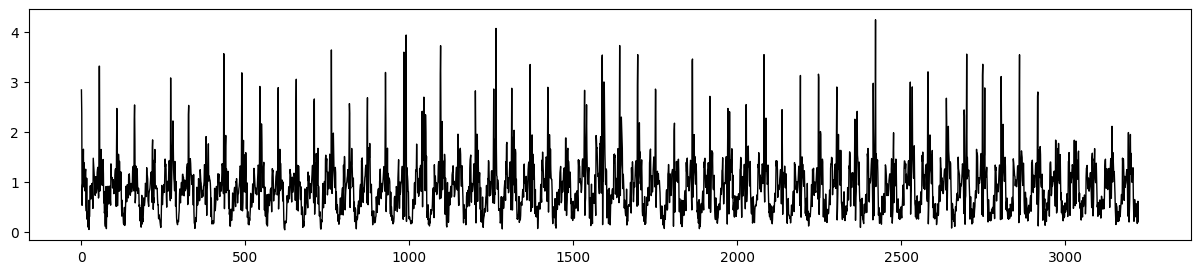

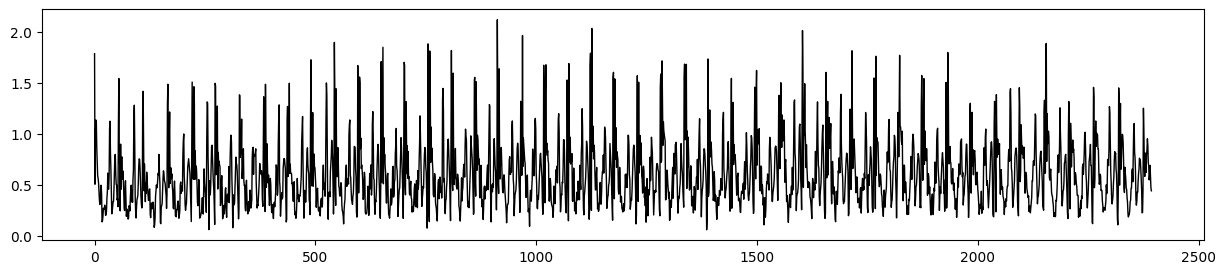

In [34]:
ts_1 = prepare_ts(4, 'wlk_7', global_start_point, global_end_point, person_start_point_map_500)
ts_2 = prepare_ts(7, 'wlk_7', global_start_point, global_end_point, person_start_point_map_500)

plt.figure(figsize=(15,3))
plt.plot(ts_1[:], color = 'black', ls = '-', lw = 1)
plt.show()

plt.figure(figsize=(15,3))
plt.plot(ts_2[:], color = 'black', ls = '-', lw = 1)
plt.show()

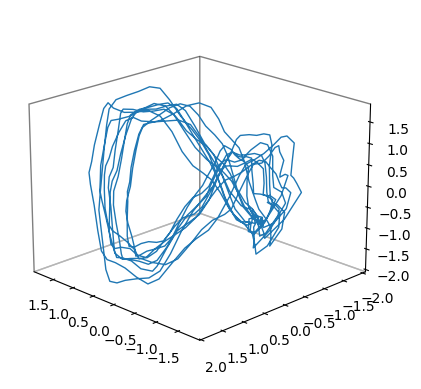

In [35]:
s = PCA(3).fit_transform(delay_embedding_matrix(ts_1, 50))
s =(s-s[:500,:].mean(axis=0))/s[:500,:].var(axis=0)**0.5
ax = plot_phase_trajectory(s[:500,:], rotation=(0, 0, 0))

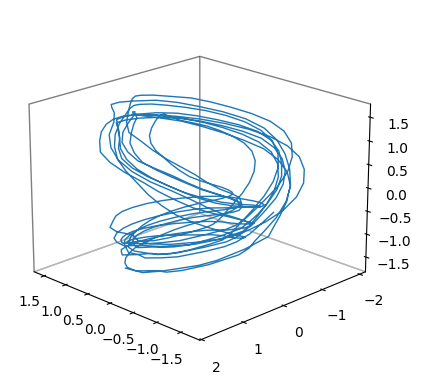

In [36]:
s = PCA(3).fit_transform(delay_embedding_matrix(ts_2, 50))
s =(s-s.mean(axis=0))/s.var(axis=0)**0.5
ax = plot_phase_trajectory(s[:500,:], rotation=(0, 0, 0))

## Phase space reconstruction

In [37]:
from numpy.linalg import inv

In [154]:
class JacobianDynamicRegression():
    
    def __init__(self, nlags, p):
        self.nlags = nlags
        self.p = p
        self.min_lenth = np.inf
        self.list_S = []
        self.list_model = []
        self.J = None
        
    def _delay_embedding_matrix(self, s, nlags, fit_intercept=False):
        """Make a matrix with delay embeddings.
    
        Parameters
        ----------
        s : np.array
            The time series data.
    
        nlags : int
            Size of time lags.
    
        Returns
        -------
        delay_embedding_matrix : np.array of shape  (len(s) - lags + 1 , lags)
            Matrix with lags.
        """ 
        N = len(s)
        delay_embedding_matrix = hankel(s[:N - nlags + 1], s[N - nlags: N])
        if fit_intercept:
            delay_embedding_matrix = np.hstack((np.ones((delay_embedding_matrix.shape[0], 1)), delay_embedding_matrix))
        return delay_embedding_matrix

    def _make_subspace(self, list_ts, nlags):
        list_S = []
        for ts in list_ts:
            X = self._delay_embedding_matrix(ts, nlags)
            cur_min_lenth = X.shape[0]
            
            if cur_min_lenth < self.min_lenth:
                self.min_lenth = cur_min_lenth
                
            model = PCA(self.p).fit(X)
            S = model.transform(X)

            self.list_model.append(model)
            list_S.append(S)
            
        list_S = [S[:self.min_lenth, :] for S in list_S]
        return list_S
        
    def _calculate_jacobian(self, list_S, X_theta):
        self.n_theta = X_theta.shape[0]
        self.dim_theta = X_theta.shape[1]
        
        ts_index = [(i, j) for i in range(self.n_theta) for j in range(self.n_theta) if i != j]
        
        list_delta_S = []
        list_theta_times_S = []
        
        for i, j in ts_index:
            list_delta_S.append(list_S[j] - list_S[i])
            
            delta_theta = (X_theta[j, :] - X_theta[i, :])
            theta_times_S = np.outer(list_S[i], delta_theta)
            theta_times_S = theta_times_S.reshape((self.min_lenth, -1))
            list_theta_times_S.append(theta_times_S)

        matrix_delta_S = np.concatenate(list_delta_S, axis=0)
        matrix_theta_times_S = np.concatenate(list_theta_times_S, axis=0)
        
        # J = inv(matrix_theta_times_S.T @ matrix_theta_times_S) @ matrix_theta_times_S.T @ matrix_delta_S
        # self.J = J.reshape((self.p, self.dim_theta, self.p))
        # = J.reshape((self.p, self.dim_theta, self.p))
        self.J = inv(matrix_theta_times_S.T @ matrix_theta_times_S) @ matrix_theta_times_S.T @ matrix_delta_S
        return J

    def _find_nearest_dynamic_system(self, x_theta):
        i_nn = np.argmin(np.sum((self.X_theta - x_theta)**2, axis=1)**0.5)
        x_theta_nn = self.X_theta[i_nn, :]
        return i_nn, x_theta_nn

    def params(self):
        return {
            'phase_space_model': self.list_model,
            'jacobian': self.J,
            'nlags': self.nlags,
            'p': self.p
        }

    def fit(self, list_ts, X_theta):
        self.X_theta = np.array(X_theta)
        list_S = self._make_subspace(list_ts, self.nlags)
        J = self._calculate_jacobian(list_S, X_theta)
        return self

    def transform(self, ts, x_theta, flg_near_model = False):
        i_nn, x_theta_nn = self._find_nearest_dynamic_system(x_theta)
        X_ts = self._delay_embedding_matrix(ts, self.nlags)
        S = self.list_model[i_nn].transform(X_ts)
        
        if flg_near_model:
            return S
        else:
            delta_theta = x_theta - x_theta_nn
            # J_0 = np.identity(self.p) + np.einsum('ijk,j->ik', self.J, delta_theta)
            
            theta_times_S = np.outer(S, delta_theta)
            theta_times_S = theta_times_S.reshape((S.shape[0], -1))
            S = S + theta_times_S @ self.J
            return S
            
    def inverse_transform(self, S, x_theta, flg_near_model = False):
        i_nn, x_theta_nn = self._find_nearest_dynamic_system(x_theta)
        X = self.list_model[i_nn].inverse_transform(S)
        
        if flg_near_model:
            return X
        else:
            delta_theta = x_theta - x_theta_nn
            # J_0 = np.identity(self.p) + np.einsum('ijk,j->ik', self.J, delta_theta)
            # S = S @ inv(J_0)
            # X = self.list_model[i_nn].inverse_transform(S)

            theta_times_S = np.outer(S, delta_theta)
            theta_times_S = theta_times_S.reshape((S.shape[0], -1))
            return X

In [221]:
global_start_point = 500
global_end_point = None
person_start_point_map_500 = {
    1: 5-1,
    2: 6,
    3: 9,
    4: 45,
    5: 13-4,
    6: 16,
    7: 63,
    8: 68,
    9: 69,
    10: 47,
    11: 29,
    12: 40,
    13: 44-5,
    14: 13,
    15: 49,
    16: 3-1,
    17: 13,
    18: 8,
    19: 26+10,
    20: 40,
    21: 46,
    22: 16,
    23: 47-8,
    24: 34-6
}

# Точность на новых временных рядах

In [233]:
list_ts = []
for person in range(1, 25):
    print(person, end=' ')
    ts = make_ts(person, 'wlk_7')[global_start_point+person_start_point_map_500[person]:global_end_point]
    ts = (ts - ts.mean())/(ts.var()**.5)
    list_ts.append(ts)
    

theta_all =  pd.read_csv('./../data/A_DeviceMotion_data/data_subjects_info.csv').drop(columns=['code'])
theta_all = ((theta_all - theta_all.mean())/(theta_all.var()**.5)).to_numpy()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [259]:
def make_experimnt(n_ts_train, nlags, p):
    list_ts_train = list_ts[:n_ts_train]
    theta_all_train = theta_all[:n_ts_train,:]
    
    theta_all_test = theta_all[n_ts_train:,:]
    list_ts_test = list_ts[n_ts_train:]
    
    model = JacobianDynamicRegression(nlags,3).fit(list_ts_train, theta_all_train)
    r2_mean = 0
    for ts_i, theta_i in zip(list_ts_test, theta_all_test):

        
        X_true = delay_embedding_matrix(ts_i, nlags)
        
        tmp_model = PCA(model.params()['p']).fit(X_true)
        
        S_true = tmp_model.transform(delay_embedding_matrix(ts_i, nlags))
        S_near =  model.transform(ts_i, theta_i, flg_near_model=True)
        S_suggest = model.transform(ts_i, theta_i)
        
        S_true = (S_true-S_true.mean(axis=0))/S_true.var(axis=0)**0.5
        S_near = (S_near-S_near.mean(axis=0))/S_near.var(axis=0)**0.5
        S_suggest = (S_suggest-S_suggest.mean(axis=0))/S_suggest.var(axis=0)**0.5
        
        X_rec_1 = tmp_model.inverse_transform(S_true)
        X_rec_2 = model.inverse_transform(S_suggest, theta_i, flg_near_model=True)
        X_rec_3 = model.inverse_transform(S_suggest, theta_i)

        a_1 = round(r2_score(X_true, X_rec_1), 4)
        a_2 = round(r2_score(X_true, X_rec_2), 4)
        a_3 = round(r2_score(X_true, X_rec_3), 4)

        if a_3 > a_2:
            metric = (
                round(r2_score(X_true, X_rec_1), 4),
                round(r2_score(X_true, X_rec_2), 4),
                round(r2_score(X_true, X_rec_3), 4)
            )
        r2_mean += a_3-a_2
    return r2_mean/(24-n_ts_train)

In [260]:
for p in range(3,8):
    for nlags in range(5,55,5):
        r2_mean_lags = []
        for n_ts_train in range(5,21):
            r2_mean_lags.append(make_experimnt(n_ts_train, nlags, p))
        r2_mean_lags = np.mean(r2_mean_lags)
        print(f'p {p} nlags {nlags} mean r2 {round(r2_mean_lags,4)}')
        # print(f'Ts count in train {n_ts_train} mean r2 {round(r2_mean,4)}')

p 3 nlags 5 mean r2 -0.0023
p 3 nlags 10 mean r2 0.0001
p 3 nlags 15 mean r2 0.0017
p 3 nlags 20 mean r2 0.0001
p 3 nlags 25 mean r2 0.0005
p 3 nlags 30 mean r2 0.0015
p 3 nlags 35 mean r2 0.0019
p 3 nlags 40 mean r2 0.002
p 3 nlags 45 mean r2 0.0019
p 3 nlags 50 mean r2 0.0026
p 4 nlags 5 mean r2 -0.0023
p 4 nlags 10 mean r2 0.0001
p 4 nlags 15 mean r2 0.0017
p 4 nlags 20 mean r2 0.0001
p 4 nlags 25 mean r2 0.0005
p 4 nlags 30 mean r2 0.0015
p 4 nlags 35 mean r2 0.0019
p 4 nlags 40 mean r2 0.002
p 4 nlags 45 mean r2 0.0019
p 4 nlags 50 mean r2 0.0026
p 5 nlags 5 mean r2 -0.0023
p 5 nlags 10 mean r2 0.0001
p 5 nlags 15 mean r2 0.0017
p 5 nlags 20 mean r2 0.0001
p 5 nlags 25 mean r2 0.0005
p 5 nlags 30 mean r2 0.0015
p 5 nlags 35 mean r2 0.0019
p 5 nlags 40 mean r2 0.002
p 5 nlags 45 mean r2 0.0019
p 5 nlags 50 mean r2 0.0026
p 6 nlags 5 mean r2 -0.0023
p 6 nlags 10 mean r2 0.0001
p 6 nlags 15 mean r2 0.0017
p 6 nlags 20 mean r2 0.0001
p 6 nlags 25 mean r2 0.0005
p 6 nlags 30 mean r2 0.

(0.2486, 0.242, 0.2433)

In [217]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 

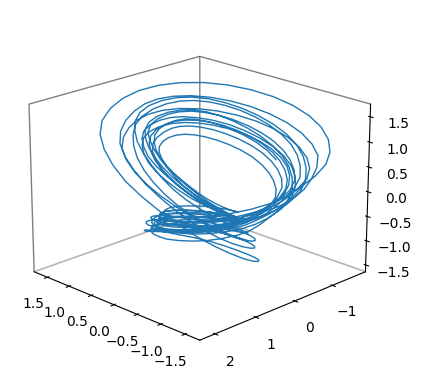

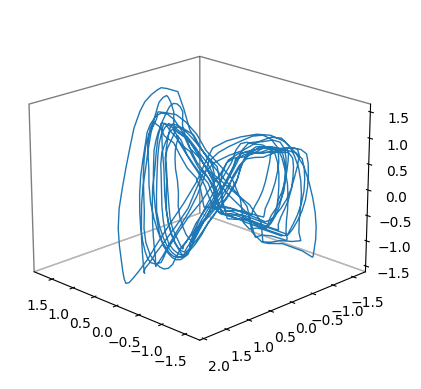

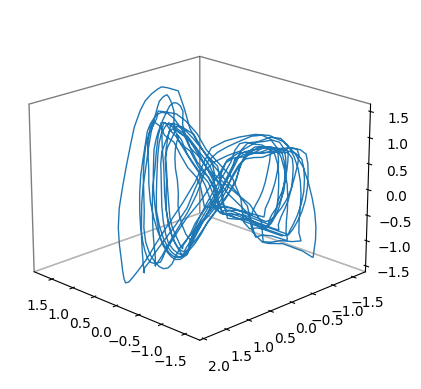

In [218]:
_ = plot_phase_trajectory(phase_trajectory=S_true[:700,:3])
_ = plot_phase_trajectory(phase_trajectory=S_near[:700,:3])
_ = plot_phase_trajectory(phase_trajectory=S_suggest[:700,:3])
# _ = plot_phase_trajectory(phase_trajectory=(list_S[i][:min_lenth,:])[:700,:3])